# VinBigData Chest X-ray: Testing & Validation [3/3]

This Jupyter Notebook is part of a series of notebooks for visualizing / Training / Testing  of  the VinBigData Chest X-ray dataset. In this notebook, we will Test and Validate our model performance.

## import necessary libraries

Imports essential Python libraries for data manipulation and mathematical operations, specifically NumPy and pandas.

In [63]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
from tqdm.notebook import tqdm

from IPython.display import display, HTML
import subprocess

# --- Visualisation Imports  ---
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = "plotly_dark"


## Set up envirement

Runs shell commands to check the NVIDIA System Management Interface (nvidia-smi) and the CUDA compiler version (nvcc --version), providing information about the GPU and CUDA toolkit available on the system.

In [64]:
!nvidia-smi
!nvcc --version

Sat Mar 16 02:38:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.09                 Driver Version: 546.09       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               2W /  60W |   3041MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [65]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

In [66]:
dist = distutils.core.run_setup("./detectron2/setup.py")
required_packages = dist.install_requires
print(required_packages)

['Pillow>=7.1', 'matplotlib', 'pycocotools>=2.0.2', 'termcolor>=1.1', 'yacs>=0.1.8', 'tabulate', 'cloudpickle', 'tqdm>4.29.0', 'tensorboard', 'fvcore<0.1.6,>=0.1.5', 'iopath<0.1.10,>=0.1.7', 'omegaconf<2.4,>=2.1', 'hydra-core>=1.1', 'black', 'packaging']


In [67]:


# Function to install packages using pip
def install_packages(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + packages)

# Call the function with the list of required packages
install_packages(required_packages)
sys.path.insert(0, os.path.abspath('./detectron2'))

In [68]:

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


print(f"CUDA Available: {torch.cuda.is_available()}")
print("detectron2:", detectron2.__version__)


if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
torch:  2.2 ; cuda:  cu121
CUDA Available: True
detectron2: 0.6
CUDA Version: 12.1
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


## Utility Imports

In [69]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
import yaml
import torch
from pathlib import Path
from typing import Any, Dict, List, Union
from tqdm import tqdm
from math import ceil
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from dataclasses import dataclass, field

setup_logger()


<Logger detectron2 (DEBUG)>

In [70]:
#Constants
THING_CLASSES = [
    "Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung Opacity", "Nodule/Mass",
    "Other lesion", "Pleural effusion", "Pleural thickening", "Pneumothorax",
    "Pulmonary fibrosis"
]
CATEGORY_NAME_TO_ID = {class_name: index for index, class_name in enumerate(THING_CLASSES)}


## Utility functions

In [71]:
def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120) -> None:
    """Save a dictionary to a YAML file."""
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)

def load_yaml(filepath: Union[str, Path]) -> Any:
    """Load a YAML file into a dictionary."""
    with open(filepath, "r") as f:
        return yaml.full_load(f)

# Data loading and preprocessing
def load_test_data(imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True) -> List[Dict]:
    """
    Prepare the dataset dictionary for VinBigData test images, with caching option.
    """
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug purposes, limit the data.

        dataset_dicts = []
        for _, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}
            image_id, _, _ = row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            image = cv2.imread(filename)
            resized_height, resized_width, _ = image.shape

            record.update({"file_name": filename, "image_id": image_id, "height": resized_height, "width": resized_width})
            dataset_dicts.append(record)

        with open(cache_path, "wb") as f:
            pickle.dump(dataset_dicts, f)
    else:
        print(f"Loading from cache {cache_path}")
        with open(cache_path, "rb") as f:
            dataset_dicts = pickle.load(f)

    return dataset_dicts

# Prediction and formatting
def format_pred(labels: np.ndarray, boxes: np.ndarray, scores: np.ndarray) -> str:
    """Format the prediction strings for submission."""
    pred_strings = [f"{label} {score} {xmin} {ymin} {xmax} {ymax}" for label, score, (xmin, ymin, xmax, ymax) in zip(labels, scores, boxes.astype(np.int64))]
    return " ".join(pred_strings)

def predict_batch(predictor: DefaultPredictor, im_list: List[np.ndarray]) -> List:
    """Run model prediction on a batch of images."""
    inputs_list = []
    for original_image in im_list:
        if predictor.input_format == "RGB":
            original_image = original_image[:, :, ::-1]

        image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
        inputs = {"image": image, "height": original_image.shape[0], "width": original_image.shape[1]}
        inputs_list.append(inputs)

    with torch.no_grad():
        predictions = predictor.model(inputs_list)
    return predictions

In [72]:
@dataclass

class Flags:
    """Configuration flags."""
    # Providing default values for all fields to allow no-argument instantiation
    imgdir_name: str = "proc_data_512"
    lr_scheduler_name: str = "WarmupCosineLR"
    outdir: str = "results/test_512x512"
    split_mode: str = "all_train"
    train_data_type: str = "original"
    base_lr: float = 0.001
    debug: bool = False
    eval_period: int = 2000
    ims_per_batch: int = 2
    iter: int = 30000
    num_workers: int = 4
    roi_batch_size_per_image: int = 512
    seed: int = 111
    use_class14: bool = False
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        """Updates the Flags object with values from a given dictionary."""
        for key, value in param_dict.items():
            setattr(self, key, value)
        return self

## Main Model Testing

In [73]:
def remove_existing_dataset(dataset_name):
    """
    Removes an existing dataset registration from Detectron2's DatasetCatalog and MetadataCatalog.
    """
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
        print(f"Removed existing dataset registration for '{dataset_name}'.")
    if dataset_name in MetadataCatalog.list():
        MetadataCatalog.remove(dataset_name)
        print(f"Removed existing metadata for '{dataset_name}'.")


def main():
    # Set up paths and configurations
    input_dir = Path("data")
    trained_dir = Path("results/train_512_1500/Aug_512") 
    data_dir = input_dir / "train"

    # Load flags from YAML configuration
    flags = Flags()

    # Prepare output directory
    outdir = Path(flags.outdir)
    os.makedirs(outdir, exist_ok=True)

    # Determine image directory based on flag configuration
    imgdir = Path(flags.imgdir_name) 

    # Load metadata for test images
    test_meta_path = Path(flags.imgdir_name) / "Test_Image_Dimensions.csv"
    test_meta = pd.read_csv(test_meta_path)

    # Set up Detectron2 configuration
    cfg = get_cfg()
    original_output_dir = cfg.OUTPUT_DIR
    cfg.OUTPUT_DIR = str(outdir)
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("vinbigdata_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = flags.base_lr
    cfg.SOLVER.MAX_ITER = flags.iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(THING_CLASSES)

    # Update model weights for inference
    cfg.MODEL.WEIGHTS = str(trained_dir / "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # Custom testing threshold
    predictor = DefaultPredictor(cfg)

    # Remove existing dataset registration
    remove_existing_dataset("vinbigdata_test")

    # Register dataset
    DatasetCatalog.register("vinbigdata_test", lambda: load_test_data(imgdir, test_meta, use_cache=not flags.debug, debug=flags.debug))
    MetadataCatalog.get("vinbigdata_test").set(thing_classes=THING_CLASSES)
    metadata = MetadataCatalog.get("vinbigdata_test")
    
    # Load dataset dictionaries
    dataset_dicts = load_test_data(imgdir, test_meta, use_cache=not flags.debug, debug=flags.debug)
    if flags.debug:
        dataset_dicts = dataset_dicts[:100]  # Limit for debugging

    # Process images in batches and predict
    results_list = []
    batch_size = flags.ims_per_batch
    for i in tqdm(range(ceil(len(dataset_dicts) / batch_size)), desc="Predicting"):
        batch_dicts = dataset_dicts[batch_size * i: min(batch_size * (i + 1), len(dataset_dicts))]
        im_list = [cv2.imread(d["file_name"]) for d in batch_dicts]
        outputs_list = predict_batch(predictor, im_list)
        
        # Process predictions
        for output, d in zip(outputs_list, batch_dicts):
            image_id = d["image_id"]
            result = process_prediction(output, image_id, metadata, test_meta)
            results_list.append(result)

    # Create and save submission
    submission = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
    submission.to_csv(outdir / "submission.csv", index=False)
    print(f"Submission saved to {outdir / 'submission.csv'}")

def process_prediction(output, image_id, metadata, test_meta):
    """
    Processes a single prediction output into the competition's submission format.

    Args:
    - output: The prediction output from the model for a single image.
    - image_id: The ID of the image being processed.
    - metadata: Metadata for the dataset (unused in this function but could be useful for extensions).
    - test_meta: DataFrame containing metadata for the test images.

    Returns:
    A dictionary with keys 'image_id' and 'PredictionString' for the submission.
    """
    # Extracting instance predictions
    instances = output["instances"]
    if len(instances) == 0:
        return {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
    
    # Extracting predicted classes, boxes, and scores
    pred_boxes = instances.pred_boxes.tensor.cpu().numpy()
    pred_classes = instances.pred_classes.cpu().numpy()
    scores = instances.scores.cpu().numpy()

    # Find original image dimensions
    original_height, original_width = test_meta[test_meta["image_id"] == image_id][["dim0", "dim1"]].values[0]


    # Format prediction string
    pred_strings = []
    for (xmin, ymin, xmax, ymax), pred_class, score in zip(pred_boxes, pred_classes, scores):
        # Scaling bounding boxes back to original dimensions may be needed here
        pred_strings.append(f"{pred_class} {score:.4f} {xmin} {ymin} {xmax} {ymax}")

    prediction_string = " ".join(pred_strings)
    return {"image_id": image_id, "PredictionString": prediction_string}



In [75]:
if __name__ == "__main__":
    flags = Flags()
    main()

[03/16 02:38:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from results\train_512_1500\Aug_512\model_final.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


Removed existing dataset registration for 'vinbigdata_test'.
Removed existing metadata for 'vinbigdata_test'.
Loading from cache dataset_dicts_cache_test_debug0.pkl


Predicting: 100%|██████████| 1500/1500 [01:55<00:00, 13.03it/s]


Submission saved to results\test_512x512\submission.csv


## Result Visualisation

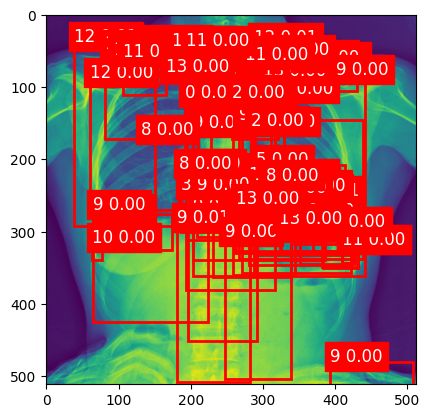

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

# Load the submission file
submission_df = pd.read_csv('results/test_512x512/submission.csv')

# Assuming test_meta contains the image dimensions
test_meta = pd.DataFrame({
    'image_id': ['8dec5497ecc246766acfba5a4be4e619', 'd1a36615c86adaaef3b2da10ddcd19e9'],
    'dim0': [2430, 2836],  # Corresponds to height
    'dim1': [1994, 2336]   # Corresponds to width
})
def draw_predictions_matplotlib(image_id, predictions, test_meta, img_dir):
    # Find image dimensions
    dims = test_meta[test_meta["image_id"] == image_id][["dim0", "dim1"]].values[0]
    original_height, original_width = dims
    
    # Load the image
    image_path = f"{img_dir}/{image_id}.png"  # Ensure the path is correct
    image = Image.open(image_path)
    
    # Create a plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Process each prediction
    prediction_items = predictions.split()
    for i in range(0, len(prediction_items), 6):
        label, score, xmin, ymin, xmax, ymax = prediction_items[i:i+6]
        # Convert string to appropriate types
        label = int(label)
        score, xmin, ymin, xmax, ymax = map(float, (score, xmin, ymin, xmax, ymax))
        
        # Draw rectangle
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Optionally, add text with label and score
        plt.text(xmin, ymin, f'{label} {score:.2f}', color='white', fontsize=12, backgroundcolor='red')
    
    plt.show()

# Example usage
image_id = 'd1a36615c86adaaef3b2da10ddcd19e9'
predictions = submission_df[submission_df["image_id"] == image_id]["PredictionString"].iloc[0]
img_dir = 'proc_data_512/test'  # Update this path to where your images are stored

draw_predictions_matplotlib(image_id, predictions, test_meta, img_dir)
